<a href="https://colab.research.google.com/github/JairAlbertoHuertaDiaz45/Simulaci-n-II/blob/main/Variables_de_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Huerta Díaz Jair Alberto**

Reducción de la Varianza

Variables de control

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, Optional

In [21]:
def g(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + x**2)

In [22]:
def theoretical_cov_gU() -> float:
    return 0.5 * np.log(2.0) - np.pi / 8.0

In [23]:
def mc_crudo_vectorizado(
    N: int,
    n: int,
    func=g,
    a: float = 0.0,
    b: float = 1.0,
    seed: Optional[int] = None,
) -> Tuple[float, float, float, np.ndarray]:
    # N: puntos por réplica, n: réplicas independientes
    # devuelve: (media_estimator, var_muestral, tiempo_promedio_por_replica, array_de_thetas)

    # generador reproducible
    rng = np.random.default_rng(seed)

    # medir tiempo
    t0 = time.perf_counter()

    # U tiene forma (n, N)
    U = rng.random((n, N))

    # evaluamos la función y promediamos por fila
    Xs = func(a + U * (b - a)).mean(axis=1) * (b - a)

    t1 = time.perf_counter()

    mean_theta = float(Xs.mean())
    var_theta = float(Xs.var(ddof=1)) if n > 1 else 0.0
    tiempo_promedio = (t1 - t0) / n

    return mean_theta, var_theta, tiempo_promedio, Xs

In [24]:
# -------------- MC con variable de control vectorizado --------------
def mc_control_variate_vectorizado(
    N: int,
    n: int,
    func=g,
    a: float = 0.0,
    b: float = 1.0,
    seed: Optional[int] = None,
    use_theoretical_c: bool = True,
) -> Tuple[dict, np.ndarray, np.ndarray, np.ndarray]:
    # Calcula Xs (estimadores crudos), Ys (media de U) y Zs (estimadores ajustados)

    rng = np.random.default_rng(seed)
    t0 = time.perf_counter()

    # generamos todas las muestras de una vez (n x N)
    U = rng.random((n, N))

    # Xs: estimador crudo por réplica; Ys: media de U por réplica
    Xs = func(a + U * (b - a)).mean(axis=1) * (b - a)
    Ys = U.mean(axis=1)

    t1 = time.perf_counter()

    # obtenemos la constante c* (teórica) o la estimamos por muestra
    if use_theoretical_c:
        cov_gU = theoretical_cov_gU()
        # Var(U) = 1/12 => c* = -Cov/Var = -12 * Cov
        c_star = -12.0 * cov_gU
    else:
        # estimador por muestra: c_hat = -Cov(X,Y)/Var(Y)
        cov_hat = np.cov(Xs, Ys, ddof=1)[0, 1]
        var_Y_hat = Ys.var(ddof=1)
        c_star = -cov_hat / var_Y_hat

    # estimador ajustado Z
    Zs = Xs + c_star * (Ys - 0.5)

    stats = {
        'mean_X': float(Xs.mean()),
        'var_X': float(Xs.var(ddof=1)) if n > 1 else 0.0,
        'se_mean_X': float(np.std(Xs, ddof=1) / np.sqrt(n)) if n > 1 else 0.0,
        'mean_Z': float(Zs.mean()),
        'var_Z': float(Zs.var(ddof=1)) if n > 1 else 0.0,
        'se_mean_Z': float(np.std(Zs, ddof=1) / np.sqrt(n)) if n > 1 else 0.0,
        'c_star': float(c_star),
        'tiempo_promedio_por_replica': (t1 - t0) / n,
    }

    return stats, Xs, Ys, Zs

In [25]:
def print_report_and_plot(N=1000, n=200, seed=123, use_theoretical_c=True, bins=30):
    mean_X, var_X, t_X, Xs = mc_crudo_vectorizado(N, n, seed=seed)
    stats, Xs2, Ys, Zs = mc_control_variate_vectorizado(N, n, seed=seed, use_theoretical_c=use_theoretical_c)

    # valor verdadero de la integral de g en [0,1] = arctan(1)-arctan(0) = pi/4
    true_value = np.arctan(1.0) - np.arctan(0.0)

    print(f'Resultados (N={N}, n={n}, seed={seed})')
    print('-----------------------------------------------')
    print(f'Valor verdadero (integral) = {true_value:.8f} (pi/4)')
    print(f"MC crudo:     media = {mean_X:.8f}, var (muestral) = {var_X:.8e}, tiempo/replica = {t_X:.6e}s")
    print(f"MC control:   media = {stats['mean_Z']:.8f}, var (muestral) = {stats['var_Z']:.8e}, tiempo/replica = {stats['tiempo_promedio_por_replica']:.6e}s")

    # Reducción de Varianza
    red = 100.0 * (var_X - stats['var_Z']) / var_X if var_X > 0 else 0.0
    print(f'Reducción relativa de varianza: {red:.2f}%')
    print(f"Constante usada c* = {stats['c_star']:.6f} (teórica? {use_theoretical_c})")

    # histograma comparativo (mismas bins para ambas distribuciones)
    bins_edge = np.histogram_bin_edges(np.concatenate([Xs, Zs]), bins=bins)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    axs[0].hist(Xs, bins=bins_edge, density=True, alpha=0.6)
    axs[0].axvline(Xs.mean(), linestyle='--')
    axs[0].axvline(true_value, color='k', linewidth=1, label='valor real')
    axs[0].set_title('MC crudo')
    axs[0].legend()

    axs[1].hist(Zs, bins=bins_edge, density=True, alpha=0.6)
    axs[1].axvline(Zs.mean(), linestyle='--')
    axs[1].axvline(true_value, color='k', linewidth=1, label='valor real')
    axs[1].set_title('Con variable de control')
    axs[1].legend()

    plt.suptitle('Comparación: MC crudo vs variable de control')
    plt.tight_layout()
    plt.show()

--- Ejecutando demo rápida ---
Resultados (N=1000, n=200, seed=42)
-----------------------------------------------
Valor verdadero (integral) = 0.78539816 (pi/4)
MC crudo:     media = 0.78542683, var (muestral) = 2.44457258e-05, tiempo/replica = 3.594850e-05s
MC control:   media = 0.78541569, var (muestral) = 3.12339368e-07, tiempo/replica = 3.285414e-05s
Reducción relativa de varianza: 98.72%
Constante usada c* = 0.553506 (teórica? True)


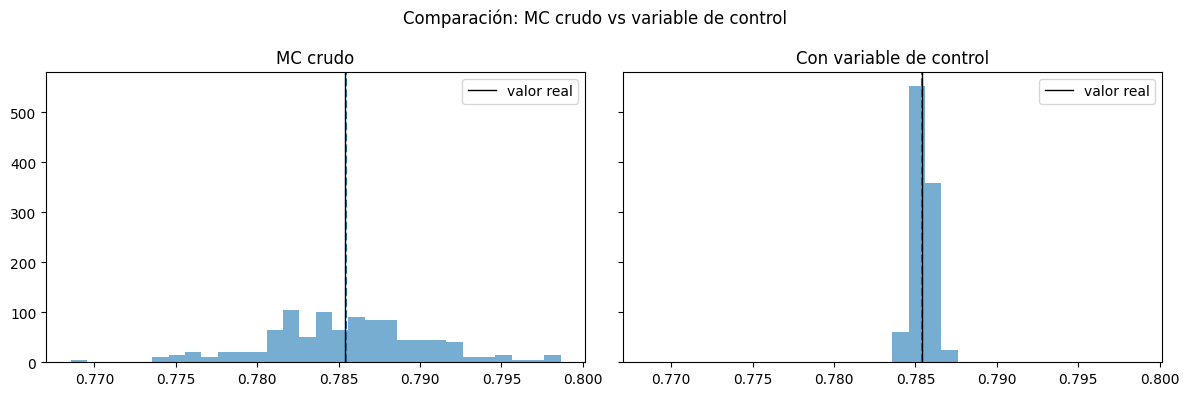

In [26]:
if __name__ == '__main__':
    # parámetros por defecto (cámbialos para experimentar)
    N = 1000
    n = 200
    seed = 42

    print('--- Ejecutando demo rápida ---')
    print_report_and_plot(N=N, n=n, seed=seed, use_theoretical_c=True, bins=30)
